# Creating a Logistic Regression model with Hyperparameter Tuning 

Instead of doing a simple logistic regression, in this noteboook we use RandomizedSearchCV and cross validation to find good hyperparameters for the logistic regression model. 

In addition, after categorical attributes have been converted to numerical attributes using dummy variables, a correlation heatmap will be used to drop additional attributes that have low correlation with the target attribute.

In [1]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# reading test and training data

train = pd.read_csv('..\\..\\Data\\titanic_train.csv')
test = pd.read_csv('..\\..\\Data\\titanic_test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Check if the dataset is balanced

<AxesSubplot:xlabel='Survived', ylabel='count'>

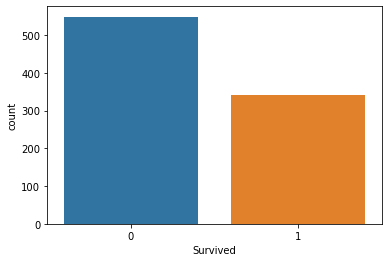

In [6]:
sns.countplot(x = 'Survived', data = train)

In [7]:
#saving test data index for writing final file

Final_Index = test['PassengerId']

### Check for missing values to drop/replace them 

<AxesSubplot:>

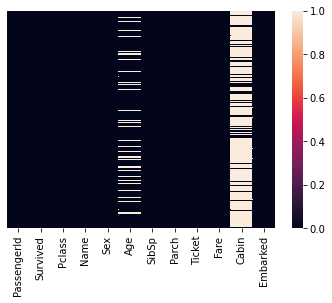

In [8]:
#checking for null values

sns.heatmap(train.isnull(),yticklabels = False)

In [9]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

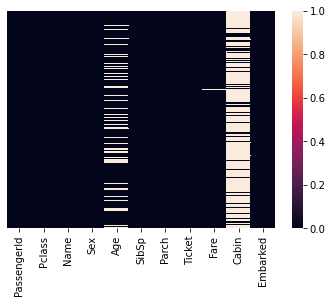

In [10]:
sns.heatmap(test.isnull(),yticklabels = False)

In [11]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Use mean to replace missing values 

Since there are a lof of missing values for 'Cabin', we will drop this column later. The next biggest attibute with missing values is 'Age', since there aren't a lot of missing values for this column we will look at the correlaton between different arributes and replace the missing values instead of dropping them.

In [12]:
# check correlation of 'Age' with other attributes
train.corr()['Age']

PassengerId    0.036847
Survived      -0.077221
Pclass        -0.369226
Age            1.000000
SibSp         -0.308247
Parch         -0.189119
Fare           0.096067
Name: Age, dtype: float64

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

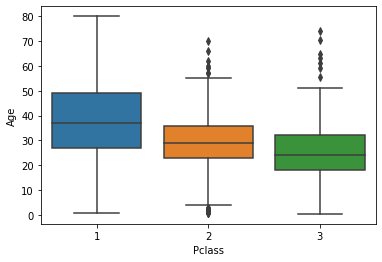

In [13]:
# 'Age' will be used as it has the highest correlation
sns.boxplot(x = 'Pclass', y = 'Age', data = train)

In [14]:
# get average age
train.groupby('Pclass').mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

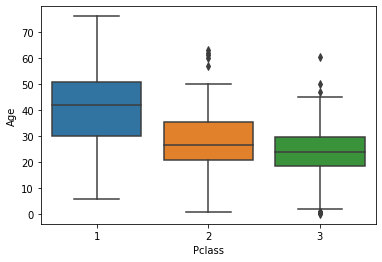

In [15]:
sns.boxplot(x = 'Pclass', y = 'Age', data = test)

In [16]:
test.groupby('Pclass').mean()['Age']

Pclass
1    40.918367
2    28.777500
3    24.027945
Name: Age, dtype: float64

In [17]:
# write functions to replace missing values of age based on passenger class

def replace_train_age(df):
    age = df[0]
    pclass = df[1]
    if pd.isnull(age):

        if pclass == 1:
            return 38

        elif pclass == 2:
            return 30

        else:
            return 20

    else:
        return age
        
def replace_test_age(df):
    age = df[0]
    pclass = df[1]
    if pd.isnull(age):

        if pclass == 1:
            return 41

        elif pclass == 2:
            return 29

        else:
            return 24

    else:
        return age

In [18]:
# applying function to fill null values

train['Age'] = train[['Age','Sex']].apply(replace_train_age, axis = 1)
test['Age'] = test[['Age','Sex']].apply(replace_test_age, axis = 1)

In [19]:
print("Train data:\n",train.isnull().sum(),"\n\nTest Data")
print(test.isnull().sum())

Train data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

Test Data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [20]:
# check correlation of 'Fare' with other attributes
train.corr()['Fare']

PassengerId    0.012658
Survived       0.257307
Pclass        -0.549500
Age            0.116500
SibSp          0.159651
Parch          0.216225
Fare           1.000000
Name: Fare, dtype: float64

In [21]:
# as 'Age' is highly correlated with 'Pclass', check the Pclass of the missing fare value in test data
test[test['Fare'].isnull()]['Pclass']

152    3
Name: Pclass, dtype: int64

In [22]:
# we will now replace the missing 'Age' value with average age of passengers in class 3
av_fare = test[test['Pclass'] == 3]['Fare'].mean()

In [23]:
test['Fare'].fillna(value = av_fare, inplace = True)

In [24]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [25]:
 train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Drop attributes that have low correlation with target variable

In [26]:
train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.040591
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

We can see above that our target class 'Survived' has low correlation with 'PassengerId'. Additionally, we can use our intuition to guess that attributes like 'Name' and 'Ticket' may not be as important as other attributes in the classification process.

In [27]:
#dropping columns that will not play a role for prediction

train.drop(['Cabin','PassengerId','Ticket','Name'], inplace = True, axis = 1)
test.drop(['Cabin','PassengerId','Ticket','Name'], inplace = True, axis = 1)

In [28]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Dummy Variables for categorical data 

In [29]:
#get dummy values for important categorical data

sex = pd.get_dummies(train['Sex'], drop_first = True)
embark = pd.get_dummies(train['Embarked'], drop_first = True)
pclass = pd.get_dummies(train['Pclass'], drop_first = True)

In [30]:
#concatenate with original dataframe
train = pd.concat([train,sex,embark,pclass], axis = 1)

In [31]:
#do the same for test dataset

sex = pd.get_dummies(test['Sex'], drop_first = True)
embark = pd.get_dummies(test['Embarked'], drop_first = True)
pclass = pd.get_dummies(test['Pclass'], drop_first = True)

In [32]:
#concatenating with original dataframe
test = pd.concat([test,sex,embark,pclass], axis = 1)

In [33]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Q,S,2,3
0,0,3,male,22.0,1,0,7.2500,S,1,0,1,0,1
1,1,1,female,38.0,1,0,71.2833,C,0,0,0,0,0
2,1,3,female,26.0,0,0,7.9250,S,0,0,1,0,1
3,1,1,female,35.0,1,0,53.1000,S,0,0,1,0,0
4,0,3,male,35.0,0,0,8.0500,S,1,0,1,0,1


In [34]:
#drop categorical columns

train.drop(['Pclass','Sex','Embarked'], inplace = True, axis = 1)
test.drop(['Pclass','Sex','Embarked'], inplace = True, axis = 1)

In [35]:
train.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S,2,3
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,1


### Recheck Correlation of target variable with all remaining attributes

Now that all attributes are in numerical form, check the correlation again using a heatmap. We want to reduce the number of attributes that have low correlation with the data as much as we can. Although some attributes may have a non-linear relationship with the target variable, we can come back and restore them if our model performs poorly. But for now, we will drop these columns.

In [36]:
tr_df_corr = train.corr()

In [37]:
mask = np.triu(np.ones_like(tr_df_corr, dtype= bool))

<AxesSubplot:>

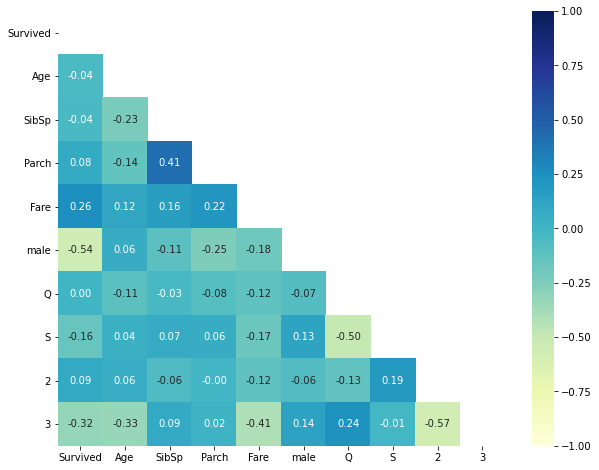

In [38]:
plt.figure(figsize = (10,8))
sns.heatmap(train.corr(), mask = mask, annot = True, fmt = ".2f", cbar = "True", vmin=-1, vmax=1, cmap = "YlGnBu")

We can see that 'Q' and 'SibSp' have very low collrealtion with the target class. Therefore, we will drop them and see how this affects the result. 

In [39]:
train.drop(['Q','SibSp'], inplace = True, axis = 1)
test.drop(['Q','SibSp'], inplace = True, axis = 1)

In [40]:
#dividing data into attributes and class labels

X_train = train.drop('Survived',axis = 1)
y_train = train['Survived']

X_test = test

Since we have 6 categorical attributes and 2 numerical attributes, let's try using the random forest classifier.

In [41]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

## RandomizedSearchCV for Hyperparameter Tuning 

In [42]:
# create a grid of parameters

max_iter = [int(x) for x in np.linspace(start = 50, stop = 1500, num = 350)]
C = [100, 10, 1.0, 0.1, 0.01, 0.001]

random_grid = {'max_iter': max_iter,
               'C': C}

print(random_grid)

{'max_iter': [50, 54, 58, 62, 66, 70, 74, 79, 83, 87, 91, 95, 99, 104, 108, 112, 116, 120, 124, 128, 133, 137, 141, 145, 149, 153, 158, 162, 166, 170, 174, 178, 182, 187, 191, 195, 199, 203, 207, 212, 216, 220, 224, 228, 232, 236, 241, 245, 249, 253, 257, 261, 266, 270, 274, 278, 282, 286, 290, 295, 299, 303, 307, 311, 315, 320, 324, 328, 332, 336, 340, 344, 349, 353, 357, 361, 365, 369, 374, 378, 382, 386, 390, 394, 398, 403, 407, 411, 415, 419, 423, 428, 432, 436, 440, 444, 448, 453, 457, 461, 465, 469, 473, 477, 482, 486, 490, 494, 498, 502, 507, 511, 515, 519, 523, 527, 531, 536, 540, 544, 548, 552, 556, 561, 565, 569, 573, 577, 581, 585, 590, 594, 598, 602, 606, 610, 615, 619, 623, 627, 631, 635, 639, 644, 648, 652, 656, 660, 664, 669, 673, 677, 681, 685, 689, 693, 698, 702, 706, 710, 714, 718, 723, 727, 731, 735, 739, 743, 747, 752, 756, 760, 764, 768, 772, 777, 781, 785, 789, 793, 797, 802, 806, 810, 814, 818, 822, 826, 831, 835, 839, 843, 847, 851, 856, 860, 864, 868, 872, 876,

In [43]:
# import libraries for cross validation

from sklearn.model_selection import RandomizedSearchCV

### Carry out cross-validation 

In [44]:
# begin cross validation, we will only try 50 fits in this case

logr_random = RandomizedSearchCV(estimator = logr, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose = 2)

logr_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] max_iter=1034, C=100 ............................................
[CV] ............................. max_iter=1034, C=100, total=   0.1s
[CV] max_iter=1034, C=100 ............................................
[CV] ............................. max_iter=1034, C=100, total=   0.0s
[CV] max_iter=1034, C=100 ............................................
[CV] ............................. max_iter=1034, C=100, total=   0.0s
[CV] max_iter=669, C=100 .............................................
[CV] .............................. max_iter=669, C=100, total=   0.0s
[CV] max_iter=669, C=100 .............................................
[CV] .............................. max_iter=669, C=100, total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_iter=669, C=100 .............................................
[CV] .............................. max_iter=669, C=100, total=   0.1s
[CV] max_iter=407, C=0.1 .............................................
[CV] .............................. max_iter=407, C=0.1, total=   0.0s
[CV] max_iter=407, C=0.1 .............................................
[CV] .............................. max_iter=407, C=0.1, total=   0.0s
[CV] max_iter=407, C=0.1 .............................................
[CV] .............................. max_iter=407, C=0.1, total=   0.0s
[CV] max_iter=1479, C=100 ............................................
[CV] ............................. max_iter=1479, C=100, total=   0.0s
[CV] max_iter=1479, C=100 ............................................
[CV] ............................. max_iter=1479, C=100, total=   0.0s
[CV] max_iter=1479, C=100 ............................................
[CV] ............................. max_iter=1479, C=100, total=   0.0s
[CV] 

C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\linear_model\_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib

[CV] ................................ max_iter=74, C=10, total=   0.1s
[CV] max_iter=74, C=10 ...............................................
[CV] ................................ max_iter=74, C=10, total=   0.0s
[CV] max_iter=311, C=100 .............................................
[CV] .............................. max_iter=311, C=100, total=   0.0s
[CV] max_iter=311, C=100 .............................................
[CV] .............................. max_iter=311, C=100, total=   0.0s
[CV] max_iter=311, C=100 .............................................
[CV] .............................. max_iter=311, C=100, total=   0.0s
[CV] max_iter=565, C=0.01 ............................................
[CV] ............................. max_iter=565, C=0.01, total=   0.0s
[CV] max_iter=565, C=0.01 ............................................
[CV] ............................. max_iter=565, C=0.01, total=   0.0s
[CV] max_iter=565, C=0.01 ............................................
[CV] .

[CV] ................................ max_iter=87, C=10, total=   0.0s
[CV] max_iter=87, C=10 ...............................................
[CV] ................................ max_iter=87, C=10, total=   0.0s
[CV] max_iter=87, C=10 ...............................................


C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\linear_model\_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib

[CV] ................................ max_iter=87, C=10, total=   0.0s
[CV] max_iter=689, C=100 .............................................
[CV] .............................. max_iter=689, C=100, total=   0.0s
[CV] max_iter=689, C=100 .............................................
[CV] .............................. max_iter=689, C=100, total=   0.0s
[CV] max_iter=689, C=100 .............................................
[CV] .............................. max_iter=689, C=100, total=   0.0s
[CV] max_iter=752, C=0.001 ...........................................
[CV] ............................ max_iter=752, C=0.001, total=   0.0s
[CV] max_iter=752, C=0.001 ...........................................
[CV] ............................ max_iter=752, C=0.001, total=   0.0s
[CV] max_iter=752, C=0.001 ...........................................
[CV] ............................ max_iter=752, C=0.001, total=   0.0s
[CV] max_iter=1254, C=0.001 ..........................................
[CV] .

[CV] ............................... max_iter=964, C=10, total=   0.0s
[CV] max_iter=964, C=10 ..............................................
[CV] ............................... max_iter=964, C=10, total=   0.0s
[CV] max_iter=964, C=10 ..............................................
[CV] ............................... max_iter=964, C=10, total=   0.0s
[CV] max_iter=594, C=1.0 .............................................
[CV] .............................. max_iter=594, C=1.0, total=   0.0s
[CV] max_iter=594, C=1.0 .............................................
[CV] .............................. max_iter=594, C=1.0, total=   0.0s
[CV] max_iter=594, C=1.0 .............................................
[CV] .............................. max_iter=594, C=1.0, total=   0.1s
[CV] max_iter=752, C=100 .............................................
[CV] .............................. max_iter=752, C=100, total=   0.1s
[CV] max_iter=752, C=100 .............................................
[CV] .

C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\linear_model\_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib

[CV] ............................... max_iter=74, C=1.0, total=   0.0s
[CV] max_iter=74, C=1.0 ..............................................
[CV] ............................... max_iter=74, C=1.0, total=   0.0s
[CV] max_iter=74, C=1.0 ..............................................
[CV] ............................... max_iter=74, C=1.0, total=   0.0s
[CV] max_iter=1254, C=100 ............................................
[CV] ............................. max_iter=1254, C=100, total=   0.0s
[CV] max_iter=1254, C=100 ............................................
[CV] ............................. max_iter=1254, C=100, total=   0.0s
[CV] max_iter=1254, C=100 ............................................
[CV] ............................. max_iter=1254, C=100, total=   0.0s
[CV] max_iter=141, C=0.1 .............................................
[CV] .............................. max_iter=141, C=0.1, total=   0.0s
[CV] max_iter=141, C=0.1 .............................................
[CV] .

C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\linear_model\_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib

[CV] .............................. max_iter=74, C=0.01, total=   0.0s
[CV] max_iter=1367, C=0.01 ...........................................
[CV] ............................ max_iter=1367, C=0.01, total=   0.0s
[CV] max_iter=1367, C=0.01 ...........................................
[CV] ............................ max_iter=1367, C=0.01, total=   0.0s
[CV] max_iter=1367, C=0.01 ...........................................
[CV] ............................ max_iter=1367, C=0.01, total=   0.0s
[CV] max_iter=1005, C=0.01 ...........................................
[CV] ............................ max_iter=1005, C=0.01, total=   0.0s
[CV] max_iter=1005, C=0.01 ...........................................
[CV] ............................ max_iter=1005, C=0.01, total=   0.0s
[CV] max_iter=1005, C=0.01 ...........................................
[CV] ............................ max_iter=1005, C=0.01, total=   0.0s
[CV] max_iter=398, C=0.01 ............................................
[CV] .

[CV] .............................. max_iter=307, C=1.0, total=   0.0s
[CV] max_iter=307, C=1.0 .............................................
[CV] .............................. max_iter=307, C=1.0, total=   0.0s
[CV] max_iter=307, C=1.0 .............................................
[CV] .............................. max_iter=307, C=1.0, total=   0.0s
[CV] max_iter=851, C=0.1 .............................................
[CV] .............................. max_iter=851, C=0.1, total=   0.0s
[CV] max_iter=851, C=0.1 .............................................
[CV] .............................. max_iter=851, C=0.1, total=   0.0s
[CV] max_iter=851, C=0.1 .............................................
[CV] .............................. max_iter=851, C=0.1, total=   0.0s
[CV] max_iter=120, C=0.001 ...........................................
[CV] ............................ max_iter=120, C=0.001, total=   0.0s
[CV] max_iter=120, C=0.001 ...........................................
[CV] .

C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\sklearn\linear_model\_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\shisk\anaconda3\envs\py37version\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\shisk\anaconda3\envs\py37version\lib

[CV] ............................ max_iter=536, C=0.001, total=   0.0s
[CV] max_iter=440, C=0.1 .............................................
[CV] .............................. max_iter=440, C=0.1, total=   0.0s
[CV] max_iter=440, C=0.1 .............................................
[CV] .............................. max_iter=440, C=0.1, total=   0.0s
[CV] max_iter=440, C=0.1 .............................................
[CV] .............................. max_iter=440, C=0.1, total=   0.0s
[CV] max_iter=1005, C=0.001 ..........................................
[CV] ........................... max_iter=1005, C=0.001, total=   0.0s
[CV] max_iter=1005, C=0.001 ..........................................
[CV] ........................... max_iter=1005, C=0.001, total=   0.0s
[CV] max_iter=1005, C=0.001 ..........................................
[CV] ........................... max_iter=1005, C=0.001, total=   0.0s
[CV] max_iter=939, C=0.01 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    8.6s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01, 0.001],
                                        'max_iter': [50, 54, 58, 62, 66, 70, 74,
                                                     79, 83, 87, 91, 95, 99,
                                                     104, 108, 112, 116, 120,
                                                     124, 128, 133, 137, 141,
                                                     145, 149, 153, 158, 162,
                                                     166, 170, ...]},
                   verbose=2)

In [45]:
# find the best set of parameters
logr_random.best_params_

{'max_iter': 407, 'C': 0.1}

In [46]:
# also check the best score
logr_random.best_score_

0.7856341189674523

In [47]:
params = logr_random.best_params_

### Choose best parameters to create the final model 

In [48]:
logr_final = LogisticRegression(**params)

logr_final.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=407)

In [49]:
predictions = logr_final.predict(test)

In [50]:
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [51]:
#reading csv file with correct classification

answers = pd.read_csv('..\\..\\Data\\gender_submission.csv')['Survived']

In [52]:
answers.head()

0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64

In [53]:
#creating prediction dataFrame

pred = pd.DataFrame(index = Final_Index, data = predictions)

## Model Evaluation

In [54]:
from sklearn.metrics import classification_report

In [55]:
#printing classification report

print(classification_report(predictions,answers))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       275
           1       0.89      0.95      0.92       143

    accuracy                           0.94       418
   macro avg       0.93      0.95      0.94       418
weighted avg       0.95      0.94      0.95       418



In [56]:
from sklearn.metrics import confusion_matrix

In [57]:
print(confusion_matrix(predictions,answers))

[[259  16]
 [  7 136]]


In [58]:
df = pred.rename(columns = {'PassengerId':'PassengerId', 0:'Survived'})
df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


### Save prediction results 

In [ ]:
df.to_csv('Prediction_Titanic_with_cross_validation.csv')